# **Gene Expression Heatplot**
This notebook generates a heat plot representing sex-biased differential gene expression as well as a plot showing the counts of differentially expressed genes per tissue.

The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

The assumptions made before rendering the heatmaps 
1. Get differential gene expression (DGE) files
2. Use the ``../assets/tissues.tsv`` to limit the tissues to those with at least 50 samples in each sex (``tissues.tsv`` was produced by a Python script)
3. Use the pattern for the differentially expressed genes **"../data/*DGE.csv"** to get all the values for the matrix.

## **Running this notebook**:

See the README for setting up prerequisites for the notebook.

## 1. Setup 

Assumes the `countGenesAndEvents.ipynb` notebook was run -- unpacking the results from the differential Gene Expression Analysis as run in the `differentialGeneExpressionAnalysis.ipynb` notebook.

In [1]:
suppressMessages({
    defaultW <- getOption("warn")  # suppress warnings for this cell
    options(warn = -1) 

    library(stringr)
    library(edgeR)
    library(pheatmap)
    library(magrittr)
    library(dplyr)
    library(ggplot2)
    library(scales)
    library(viridis)
    library(scales)
    Sys.setenv(TAR = "/bin/tar") # for gzfile
    options(warn = defaultW)
})

## 2. Making the matrices

### 2.1 Read in all the differential Gene Expression Analysis results

In [2]:
filenames <- list.files("../data", pattern="*_DGE_refined.csv", all.files=FALSE, full.names=TRUE)
message("Number of DGE files found with *_DGE.csv pattern: ",length(filenames))

Number of DGE files found with *_DGE.csv pattern: 39



### 2.2 read in the curated "../assets/tissues.tsv" 

The **`../assets/tissues.tsv`** file contains an indication to include the tissue if the file has at least **50** samples in that tissue with either **male** or **female** sex reporting

In [3]:
head(filenames)
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))
# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

message("Number of tissues with >=50 samples each in assets/tissues.tsv (tissue_reduction)",
        paste(dim(tissue_reduction), collapse=" "))

[1] "../data/adipose_subcutaneous_DGE_refined.csv"    
[2] "../data/adipose_visceral_omentum_DGE_refined.csv"
[3] "../data/adrenal_gland_DGE_refined.csv"           
[4] "../data/artery_aorta_DGE_refined.csv"            
[5] "../data/artery_coronary_DGE_refined.csv"         
[6] "../data/artery_tibial_DGE_refined.csv"


 0  1 
11 39 

Number of tissues with >=50 samples each in assets/tissues.tsv (tissue_reduction)39 5



### 2.3 model rownames from first file for the matrices

Arbitrarily using the first file, to obtain the ordered rownames for assignment to the remainder of the files in the construction of the matrix.

In [4]:
fullfilename <-filenames[1]
logFC_mat    <- read.csv(fullfilename)
pVal_mat     <- logFC_mat
logFC_mat    <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 
pVal_mat_rownames  <- logFC_mat_rownames
pVal_mat     <- logFC_mat

In [5]:
head(logFC_mat)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000006128.11,-0.9995553,-1.710357,-5.393856,9.595060e-08,5.076255e-06,6.876566
ENSG00000006747.14,0.7036181,1.180694,5.851260,7.659457e-09,6.097418e-07,8.864581
ENSG00000007264.14,0.6191870,1.732257,5.278000,1.770490e-07,8.652067e-06,5.740939
ENSG00000012817.15,-9.6063668,3.428345,-106.720113,0.000000e+00,0.000000e+00,938.070833
ENSG00000015413.9,-1.0498142,-1.419711,-6.472243,1.873454e-10,2.308827e-08,12.900625
ENSG00000018280.16,0.5978085,5.135276,4.615198,4.716222e-06,1.303003e-04,2.111960


### 2.4 function make_tissue_matrix_ready for the logFC values

This function makes a logFC matrix for each of the tissues from the **`tissue_DGE.tsv`** results. One for each of our **`tissues`** of interest.

In [14]:
all.genes<-as.character(rownames(readRDS(file = "../data/gtex.corrected.rds")))
head(all.genes)

[1] "ENSG00000223972.5" "ENSG00000227232.5" "ENSG00000278267.1"
[4] "ENSG00000243485.5" "ENSG00000237613.2" "ENSG00000268020.3"

In [23]:
all.genes<-as.character(rownames(readRDS(file = "../data/gtex.corrected.rds")))
fc.exp.mat<-matrix(rep(0), length(all.genes)*length(filenames),nrow = length(all.genes),ncol=length(filenames))

for (i in 1:length(filenames)) {
    logFC_result  <- read.csv(filenames[i])
    filegenesids  <- as.character(rownames(logFC_result))
    if (i == 1) {
        genesids <- filegenesids
    }
    genesids      <- union(as.character(genesids),filegenesids)
}
length(filenames)
idx <- str_order(genesids)
genesids <- genesids[idx]
length(genesids)
head(genesids)

[1] 39

[1] 7417

[1] "ENSG00000000005.5"  "ENSG00000000938.12" "ENSG00000001626.14"
[4] "ENSG00000002586.18" "ENSG00000002726.20" "ENSG00000002746.14"

NULL

In [57]:
files <- filenames
logFC_mat <- matrix(0.0, nrow=length(genesids), ncol = length(files))
pattern     <- "../data/*DGE_refined.csv"
pVal_mat  <- logFC_mat
rownames(logFC_mat) <- as.character(genesids)
for (i in 1:length(filenames)) {
    logFC_result  <- read.csv(filenames[i])
    filegenesids  <- as.character(rownames(logFC_result))
    # match the filegenesids in the list of unioned genesids for placing the significant gene-junction values
    # in the matrix where rows are gene-junctions and columns are tissues (filegenesids)
    for (j in 1:length(filegenesids)) {
        genesids_match <- genesids %in% filegenesids[j]
        logFC_mat[genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"logFC"]
        pVal_mat [genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"adj.P.Val"]
    }
}

display_name = tissue_reduction$display_name
colnames(logFC_mat) <- as.character(display_name)
colnames(pVal_mat)  <- as.character(display_name)

In [73]:
filenames
colnames(logFC_mat)

[1] "../data/adipose_subcutaneous_DGE_refined.csv"                 
 [2] "../data/adipose_visceral_omentum_DGE_refined.csv"             
 [3] "../data/adrenal_gland_DGE_refined.csv"                        
 [4] "../data/artery_aorta_DGE_refined.csv"                         
 [5] "../data/artery_coronary_DGE_refined.csv"                      
 [6] "../data/artery_tibial_DGE_refined.csv"                        
 [7] "../data/brain_caudate_basal_ganglia_DGE_refined.csv"          
 [8] "../data/brain_cerebellar_hemisphere_DGE_refined.csv"          
 [9] "../data/brain_cerebellum_DGE_refined.csv"                     
[10] "../data/brain_cortex_DGE_refined.csv"                         
[11] "../data/brain_frontal_cortex_ba_9_DGE_refined.csv"            
[12] "../data/brain_hippocampus_DGE_refined.csv"                    
[13] "../data/brain_hypothalamus_DGE_refined.csv"                   
[14] "../data/brain_nucleus_accumbens_basal_ganglia_DGE_refined.csv"
[15] "../data/brain_putamen_basal_ganglia_DGE_refined.csv"          
[16] "../data/brain_spinal_cord_cervical_c_1_DGE_refined.csv"       
[17] "../data/breast_mammary_tissue_DGE_refined.csv"                
[18] "../data/cells_cultured_fibroblasts_DGE_refined.csv"           
[19] "../data/cells_ebv_transformed_lymphocytes_DGE_refined.csv"    
[20] "../data/colon_sigmoid_DGE_refined.csv"                        
[21] "../data/colon_transverse_DGE_refined.csv"                     
[22] "../data/esophagus_gastroesophageal_junction_DGE_refined.csv"  
[23] "../data/esophagus_mucosa_DGE_refined.csv"                     
[24] "../data/esophagus_muscularis_DGE_refined.csv"                 
[25] "../data/heart_atrial_appendage_DGE_refined.csv"               
[26] "../data/heart_left_ventricle_DGE_refined.csv"                 
[27] "../data/liver_DGE_refined.csv"                                
[28] "../data/lung_DGE_refined.csv"                                 
[29] "../data/muscle_skeletal_DGE_refined.csv"                      
[30] "../data/nerve_tibial_DGE_refined.csv"                         
[31] "../data/pancreas_DGE_refined.csv"                             
[32] "../data/pituitary_DGE_refined.csv"                            
[33] "../data/skin_not_sun_exposed_suprapubic_DGE_refined.csv"      
[34] "../data/skin_sun_exposed_lower_leg_DGE_refined.csv"           
[35] "../data/small_intestine_terminal_ileum_DGE_refined.csv"       
[36] "../data/spleen_DGE_refined.csv"                               
[37] "../data/stomach_DGE_refined.csv"                              
[38] "../data/thyroid_DGE_refined.csv"                              
[39] "../data/whole_blood_DGE_refined.csv"

[1] "Adipose (sc)"          "Adipose (v)"           "Adrenal gland"        
 [4] "Aorta"                 "Coronary artery"       "Tibial artery"        
 [7] "Caudate"               "Cerebellar hemisphere" "Cerebellum"           
[10] "Cortex"                "Frontal cortex"        "Hippocampus"          
[13] "Hypothalamus"          "Nucleus accumbens"     "Putamen"              
[16] "Spinal cord"           "Breast"                "Fibroblasts"          
[19] "EBV-lymphocytes"       "Sigmoid colon"         "Transverse colon"     
[22] "Esophagus (gej)"       "Esophagus (m)"         "Esophagus (mu)"       
[25] "Atrial appendage"      "Left ventricle"        "Liver"                
[28] "Lung"                  "Skeletal muscle"       "Tibial nerve"         
[31] "Pancreas"              "Pituitary"             "Skin (not exposed)"   
[34] "Skin (exposed)"        "Small intestine"       "Spleen"               
[37] "Stomach"               "Thyroid"               "Whole blood"

### 2.8 Calculate the correlation between the tissues using the logFC and render the heatmaps of the distance correlations

Calculate the correlation distances between the tissues using the logFC within each of the tissues.   Clustering by similar expression.

In [74]:
dist_mat <- as.matrix(cor(logFC_mat))
sum(is.na(dist_mat))
sum(!is.na(dist_mat))

[1] 0

[1] 1521

In [75]:
head(dist_mat)
max(dist_mat)
min(dist_mat)
median(dist_mat)

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
Adipose (sc),1.0000000,0.8395639,0.8260860,0.8277623,0.8302070,0.8256368,0.8251617,0.7968840,0.8066529,0.8149495,⋯,0.8593127,0.8315900,0.7445040,0.7896177,0.8092297,0.8203979,0.7853825,0.8366814,0.8181849,0.7473007
Adipose (v),0.8395639,1.0000000,0.9075506,0.9031706,0.9185964,0.8923954,0.9037984,0.8784732,0.8875825,0.8926780,⋯,0.9122941,0.9147412,0.8094626,0.8485922,0.8574945,0.9098494,0.8735382,0.9224916,0.8693529,0.8393425
Adrenal gland,0.8260860,0.9075506,1.0000000,0.9459623,0.9626908,0.9434717,0.9275850,0.9315419,0.9342186,0.9338627,⋯,0.9481063,0.9345500,0.8604412,0.8734355,0.8831328,0.9377253,0.9323345,0.9428123,0.8571071,0.8803284
Aorta,0.8277623,0.9031706,0.9459623,1.0000000,0.9612028,0.9509013,0.9170672,0.9136889,0.9232264,0.9220192,⋯,0.9400934,0.9254427,0.8415300,0.8617938,0.8759659,0.9287172,0.9050903,0.9369434,0.8705720,0.8636130
Coronary artery,0.8302070,0.9185964,0.9626908,0.9612028,1.0000000,0.9590062,0.9370107,0.9346644,0.9407833,0.9437394,⋯,0.9547118,0.9339522,0.8555052,0.8710962,0.8861871,0.9513999,0.9341676,0.9531771,0.8742195,0.8838283
Tibial artery,0.8256368,0.8923954,0.9434717,0.9509013,0.9590062,1.0000000,0.9136290,0.9148460,0.9186431,0.9237963,⋯,0.9431505,0.9123289,0.8382385,0.8568756,0.8746167,0.9231672,0.9048859,0.9285125,0.8503443,0.8682397


[1] 1

[1] 0.3456174

[1] 0.8994407

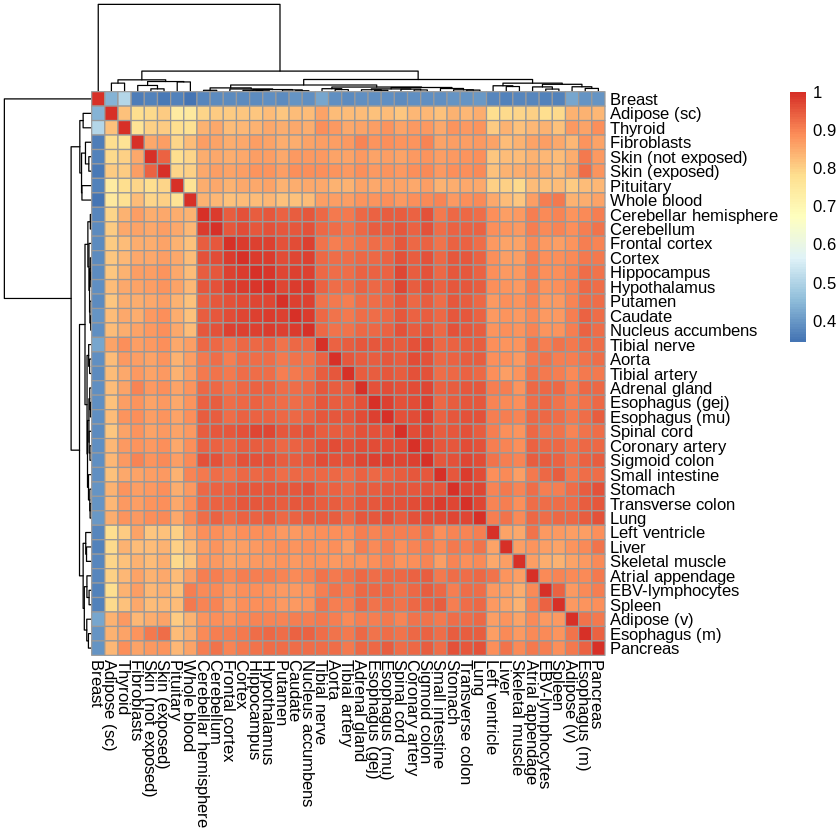

In [69]:
pheatmap(dist_mat)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/geneExpressionDistanceCorrelationHeatmapAlllogFC.pdf"))

## Appendix Metadata

For replicability and reproducibility purposes, we also print the following metadata:

### Appendix.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [12]:
figure_id   = "expressionHeatmap"

### Appendix.2. Libraries

In [13]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..

Done!


Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..

Done!




 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.4 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-08-28                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
dplyr,dplyr,1.0.2,1.0.2,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-08-18,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.0,3.28.0,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.3.2,3.3.2,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2020-06-19,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
magrittr,magrittr,1.5,1.5,/opt/conda/lib/R/library/magrittr,/opt/conda/lib/R/library/magrittr,TRUE,FALSE,2014-11-22,CRAN (R 3.6.0),NA,/opt/conda/lib/R/library
pheatmap,pheatmap,1.0.12,1.0.12,/opt/conda/lib/R/library/pheatmap,/opt/conda/lib/R/library/pheatmap,TRUE,FALSE,2019-01-04,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
repr,repr,1.1.0,1.1.0,/opt/conda/lib/R/library/repr,/opt/conda/lib/R/library/repr,TRUE,FALSE,2020-01-28,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
